In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import glob
import math
import random
import time
import datetime
from collections import defaultdict
from tqdm import tqdm, tqdm_notebook

import xml.etree.ElementTree as ET 

import cv2
plt.style.use('ggplot')

print(os.listdir("../data"))

['Annotation', 'Annotation.zip', 'all-dogs', '.DS_Store', 'all-dogs.zip']


In [6]:
image_width = 64
image_height = 64
image_channels = 3
# image_sample_size = 10000
# image_output_dir = '../output_images/'
image_input_dir = '../data/all-dogs/'
image_ann_dir = "../data/Annotation/"

In [39]:
dog_breed_dict = {}
for annotation in os.listdir(image_ann_dir):
    try:
        annotations = annotation.split('-')
        dog_breed_dict[annotations[0]] = annotations[1]
    except:
        pass

In [44]:
def get_input_image_dict(image_input_dir, labels_dict):
    image_sample_dict = defaultdict(list)
    for image in os.listdir(image_input_dir):
        filename = image.split('.')
        label_code = filename[0].split('_')[0]
        breed_name = labels_dict[label_code]
        #print('Code: {}, Breed: {}'.format(label_code, breed_name))
        if image is not None:
            image_sample_dict[breed_name].append(image)
    
    print('Created label dictionary for input images.')
    return image_sample_dict

In [45]:
image_sample_dict = get_input_image_dict(image_input_dir, dog_breed_dict)

Created label dictionary for input images.


In [46]:
def plot_class_distributions(image_sample_dict, title=''):
    class_lengths = []
    labels = []
    total_images = 0
    
    print('Total amount of dog breeds: ', len(image_sample_dict))
    
    for label, _ in image_sample_dict.items():
        total_images += len(image_sample_dict[label])
        class_lengths.append(len(image_sample_dict[label]))
        labels.append(label)
        
    print('Total amount of input images: ', total_images)
        
    plt.figure(figsize = (10,30))
    plt.barh(range(len(class_lengths)), class_lengths)
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.ylabel('Dog Breed')
    plt.xlabel('Sample size')
    plt.show()
    
    return total_images

('Total amount of dog breeds: ', 120)
('Total amount of input images: ', 20579)


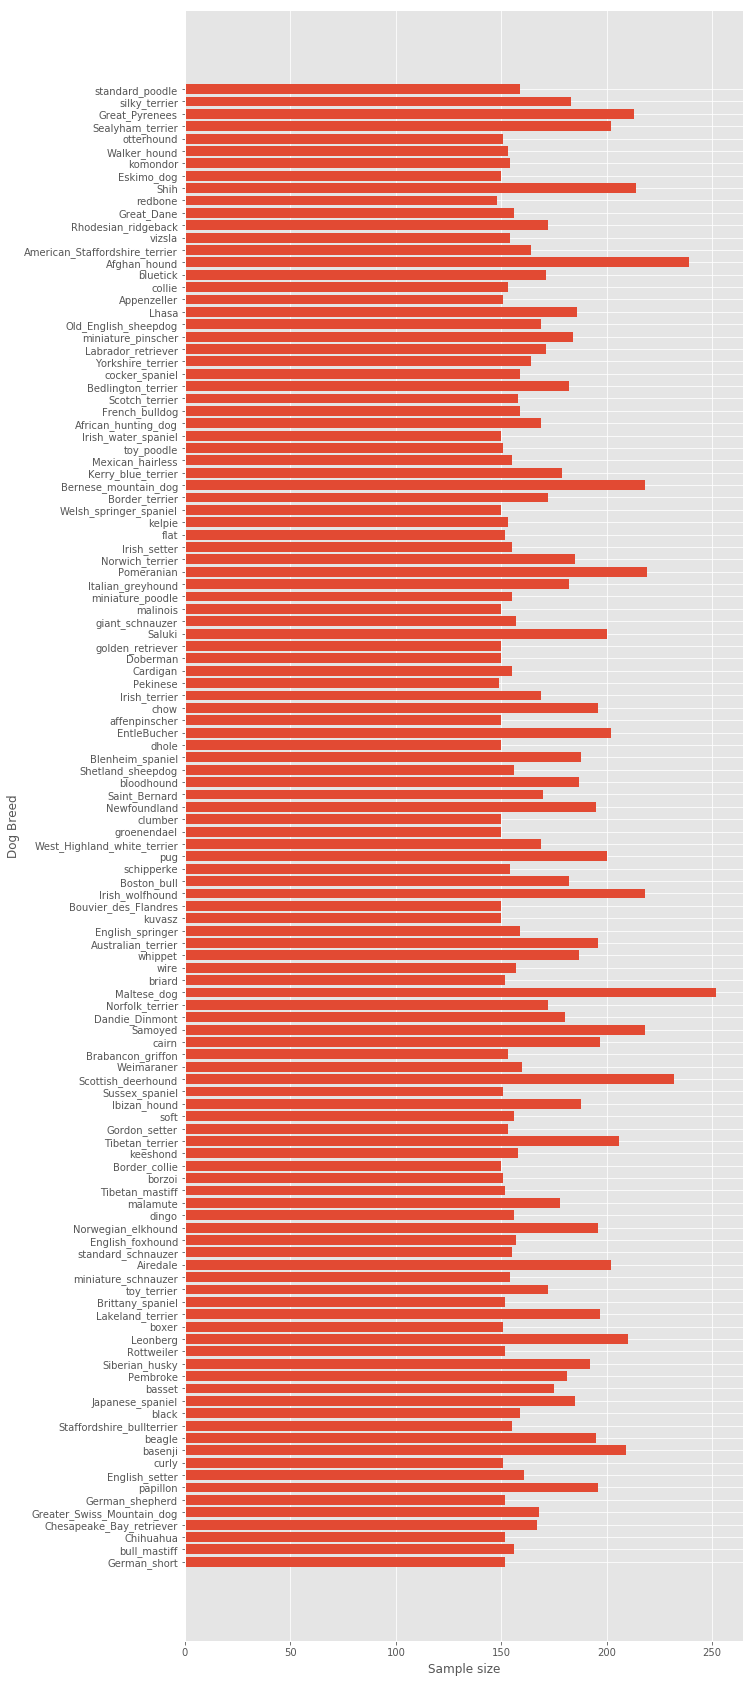

In [49]:
total_images = plot_class_distributions(image_sample_dict)